## **Task II: Classical Graph Neural Network (GNN)** 

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description. 
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures.


In [ ]:
!pip install energyflow         #Installing energyflow package to read data from
!wget https://raw.githubusercontent.com/hqucms/ParticleNet/master/tf-keras/tf_keras_model.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/GSoC2023'

/content/drive/MyDrive/GSoC2023


In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

### Dataset

The datasets are contained in twenty files with 100k jets each, and only the required files are downloaded. These are based on the samples used in [1810.05165](https://arxiv.org/abs/1810.05165). 
Each dataset consists of two components:

- X : a three-dimensional numpy array of the jets with shape  (num_data,max_num_particles,4).
- y : a numpy array of quark/gluon jet labels (quark=1 and gluon=0).

The jets are padded with zero-particles in order to make a contiguous array. The particles are given as `(pt,y,phi,pid)` values, where `pid` is the particle's PDG id. Quark jets either include or exclude c and b quarks depending on the `with_bc` argument.

In [ ]:
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt



train, val, test = 300000, 100000, 100000


# load data
X, y = qg_jets.load(train + val + test)
X = X[ :, :, :3]  #ignoring pid

# convert labels to categorical
y = to_categorical(y, num_classes = 2)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)


### Architectures

For this task, I've considered the following Graph-based architectures,


*   ParticleNet
*   ParticleNet-Lite
*   Energy Flow Networks (EFN)
*   Particle Flow Networks (PFN)

ParticleNet and ParticleNet-Lite have a lot in common when it comes to how they're built. They both use EdgeConv to help them understand the relationships between nearby points in a point-cloud, which makes them more effective than most other methods out there. The ParticleNet-Lite model provides a good balance between speed and performance.

EFN and PFN have a special internal representation for each particle, also known as "latent representation". When you add up the latent representation of all particles, it gives you an overall representation of the entire event.

Given the limited resources available, I have implemented ParticleNet-Lite and EFN. These models were chosen because they are more efficient in terms of resource utilization compared to other options available.

### ParticleNet-Lite

The paper [2] introduces a novel deep-learning approach for jet tagging by utilizing a unique way of representing jets. Rather than arranging a jet's constituent particles in a structured format such as a sequence or a tree, the approach treats a jet as an unstructured set of particles. This is similar to the point cloud representation used in computer vision to represent 3D shapes, where a shape is represented as an unordered set of points in space. As such, a jet can be thought of as a "particle cloud".

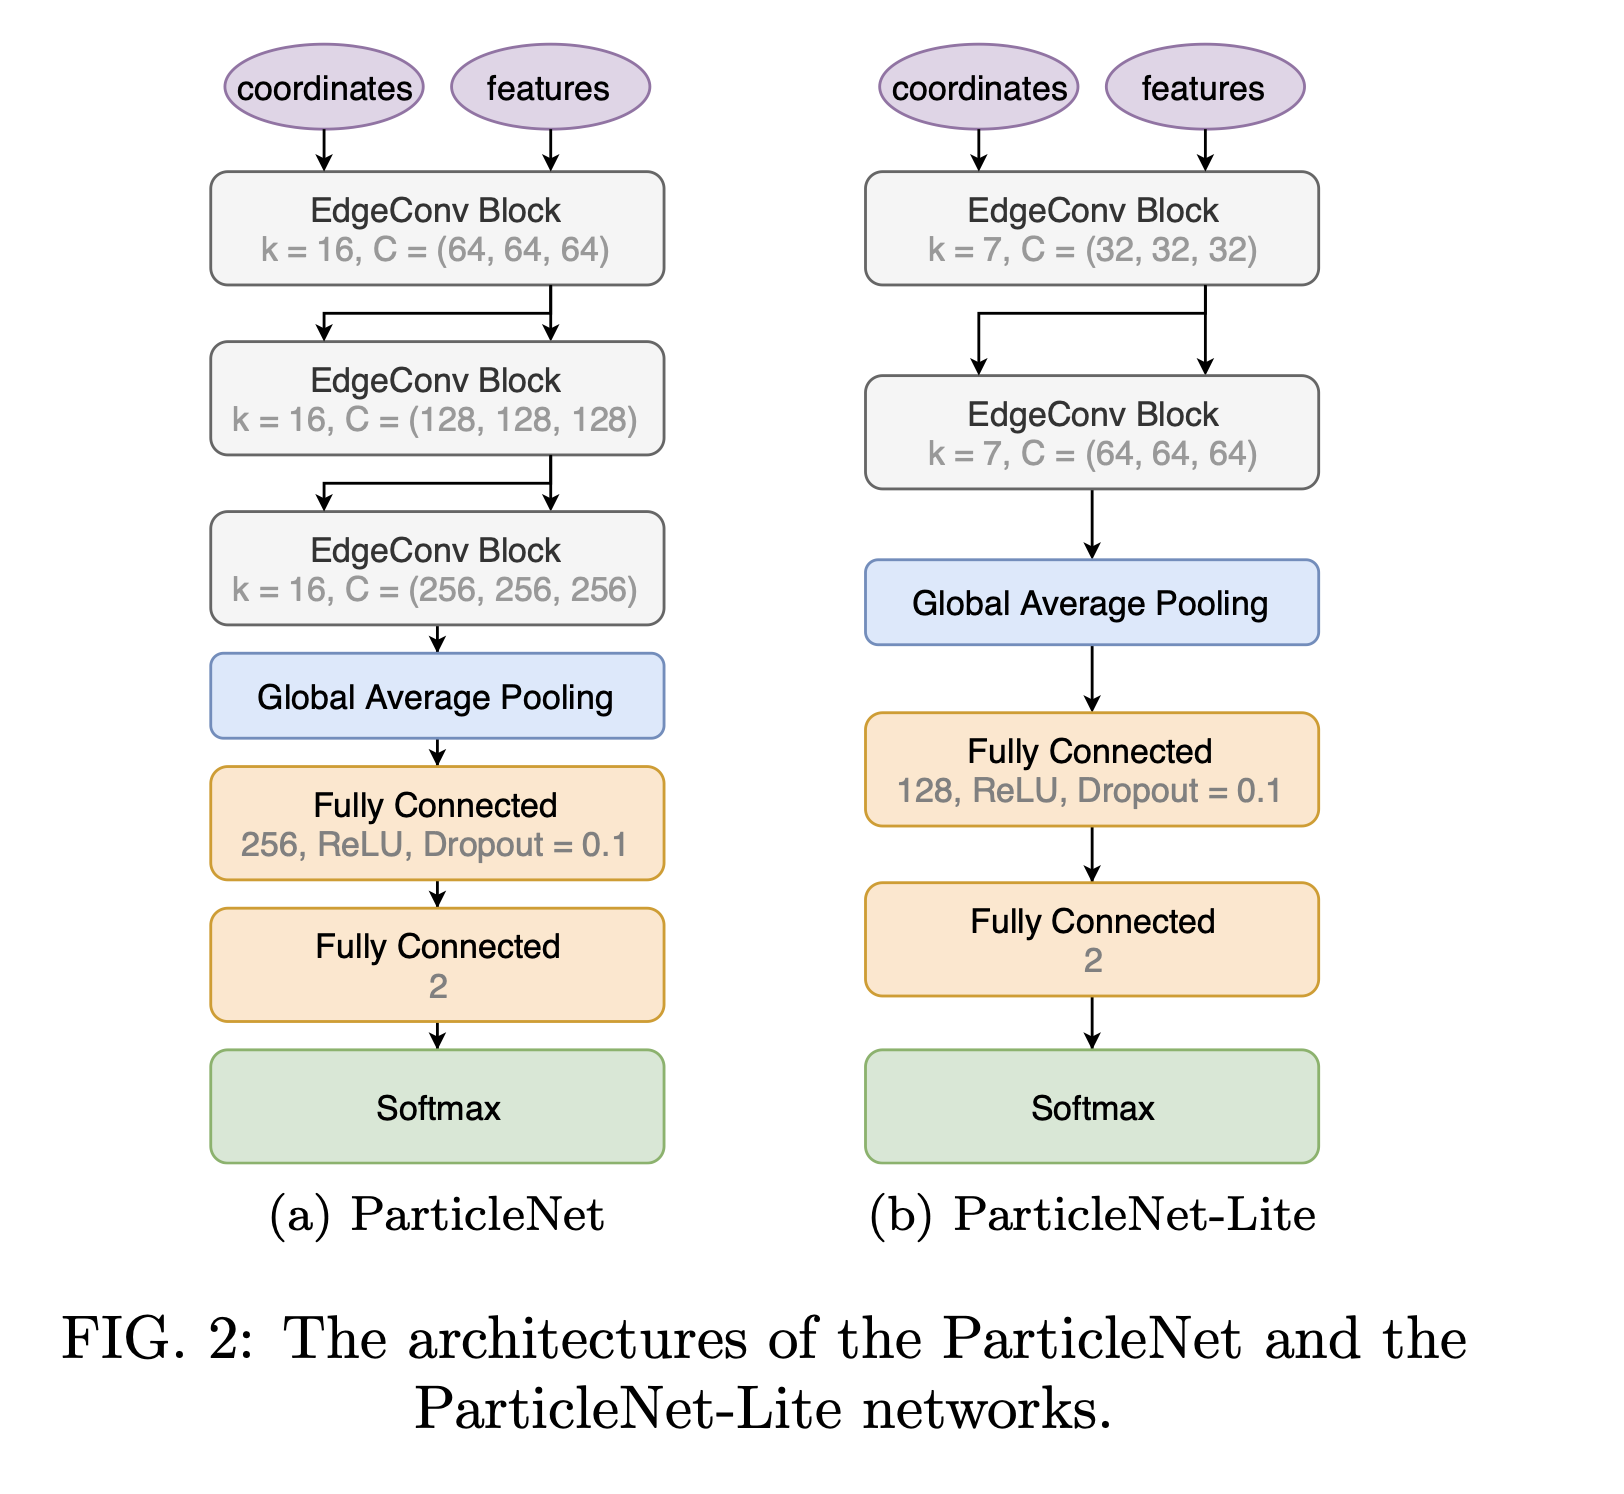

In [ ]:
dict_train = {
    'points'   : X_train[ :, :, 1:3],
    'features' : X_train, 
    'mask'     : np.array(np.sum(X_train, axis = 2) != 0, np.float32).reshape(X_train.shape[0], X_train.shape[1], 1)
}

In [ ]:
dict_test = {
    'points'   : X_test[ :, :, 1:3],
    'features' : X_test,
    'mask'     : np.array(np.sum(X_test, axis = 2) != 0, np.float32).reshape(X_test.shape[0], X_test.shape[1], 1)
}

In [ ]:
dict_val = {
    'points'   : X_val[ :, :, 1:3],
    'features' : X_val,
    'mask'     : np.array(np.sum(X_val, axis = 2) != 0, np.float32).reshape(X_val.shape[0], X_val.shape[1], 1)
}

In [ ]:
input_shapes = {
    'points'  : X_train[ :, :, 1:3].shape[1:],
    'features': X_train.shape[1:],
    'mask'    : np.array(np.sum(X_train, axis = 2) != 0, np.float32).reshape(X_train.shape[0], X_train.shape[1], 1).shape[1:]
}

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [ ]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = 2
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [ ]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 60

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [ ]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath = filepath,
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [ ]:
model.fit(dict_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          # epochs=1, # --- train only for 1 epoch here for demonstration ---
          validation_data = (dict_val, y_val),
          shuffle = True,
          callbacks = callbacks)

Epoch 1/60
      0/Unknown - 182s 0s/sample - loss: 0.4965 - accuracy: 0.7661
Epoch 1: val_accuracy improved from -inf to 0.77371, saving model to model_checkpoints/particle_net_lite_model.001.h5
293/293 [==============================] - 266s 909ms/sample - loss: 0.4965 - accuracy: 0.7661 - val_loss: 0.4867 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 2/60
  0/293 [..............................] - ETA: 0s - loss: 0.4702 - accuracy: 0.7849
Epoch 2: val_accuracy did not improve from 0.77371
293/293 [==============================] - 247s 843ms/sample - loss: 0.4702 - accuracy: 0.7849 - val_loss: 0.4876 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/60
  0/293 [..............................] - ETA: 0s - loss: 0.4603 - accuracy: 0.7902
Epoch 3: val_accuracy improved from 0.77371 to 0.78893, saving model to model_checkpoints/particle_net_lite_model.003.h5
293/293 [==============================] - 248s 846ms/sample - loss: 0.4603 - accuracy: 0.7902 - val_loss: 0.4618 - val_accuracy: 0.7889 - l

In [ ]:
from keras.models import load_model

model = load_model('model_checkpoints/particle_net_lite_model.048.h5')

test_loss, test_accuracy = model.evaluate(dict_test, y_test)

print("Loss: ", test_loss)
print("Accuracy:", test_accuracy)

3125/3125 [==============================] - 138s 44ms/step - loss: 0.4268 - accuracy: 0.8094
Loss:  0.4267784059047699
Accuracy: 0.8093799948692322


In [ ]:
train_loss, train_accuracy = model.evaluate(dict_train, y_train)

print("Loss: ", train_loss)
print("Accuracy: ", train_accuracy)

9375/9375 [==============================] - 423s 45ms/step - loss: 0.4165 - accuracy: 0.8154
Loss:  0.4165427088737488
Accuracy:  0.8154066801071167


In [ ]:
val_loss, val_accuracy = model.evaluate(dict_val, y_val)

print("Loss: ", val_loss)
print("Accuracy: ", val_accuracy)

3125/3125 [==============================] - 139s 44ms/step - loss: 0.4275 - accuracy: 0.8087
Loss:  0.4274614453315735
Accuracy:  0.8087300062179565


### EFN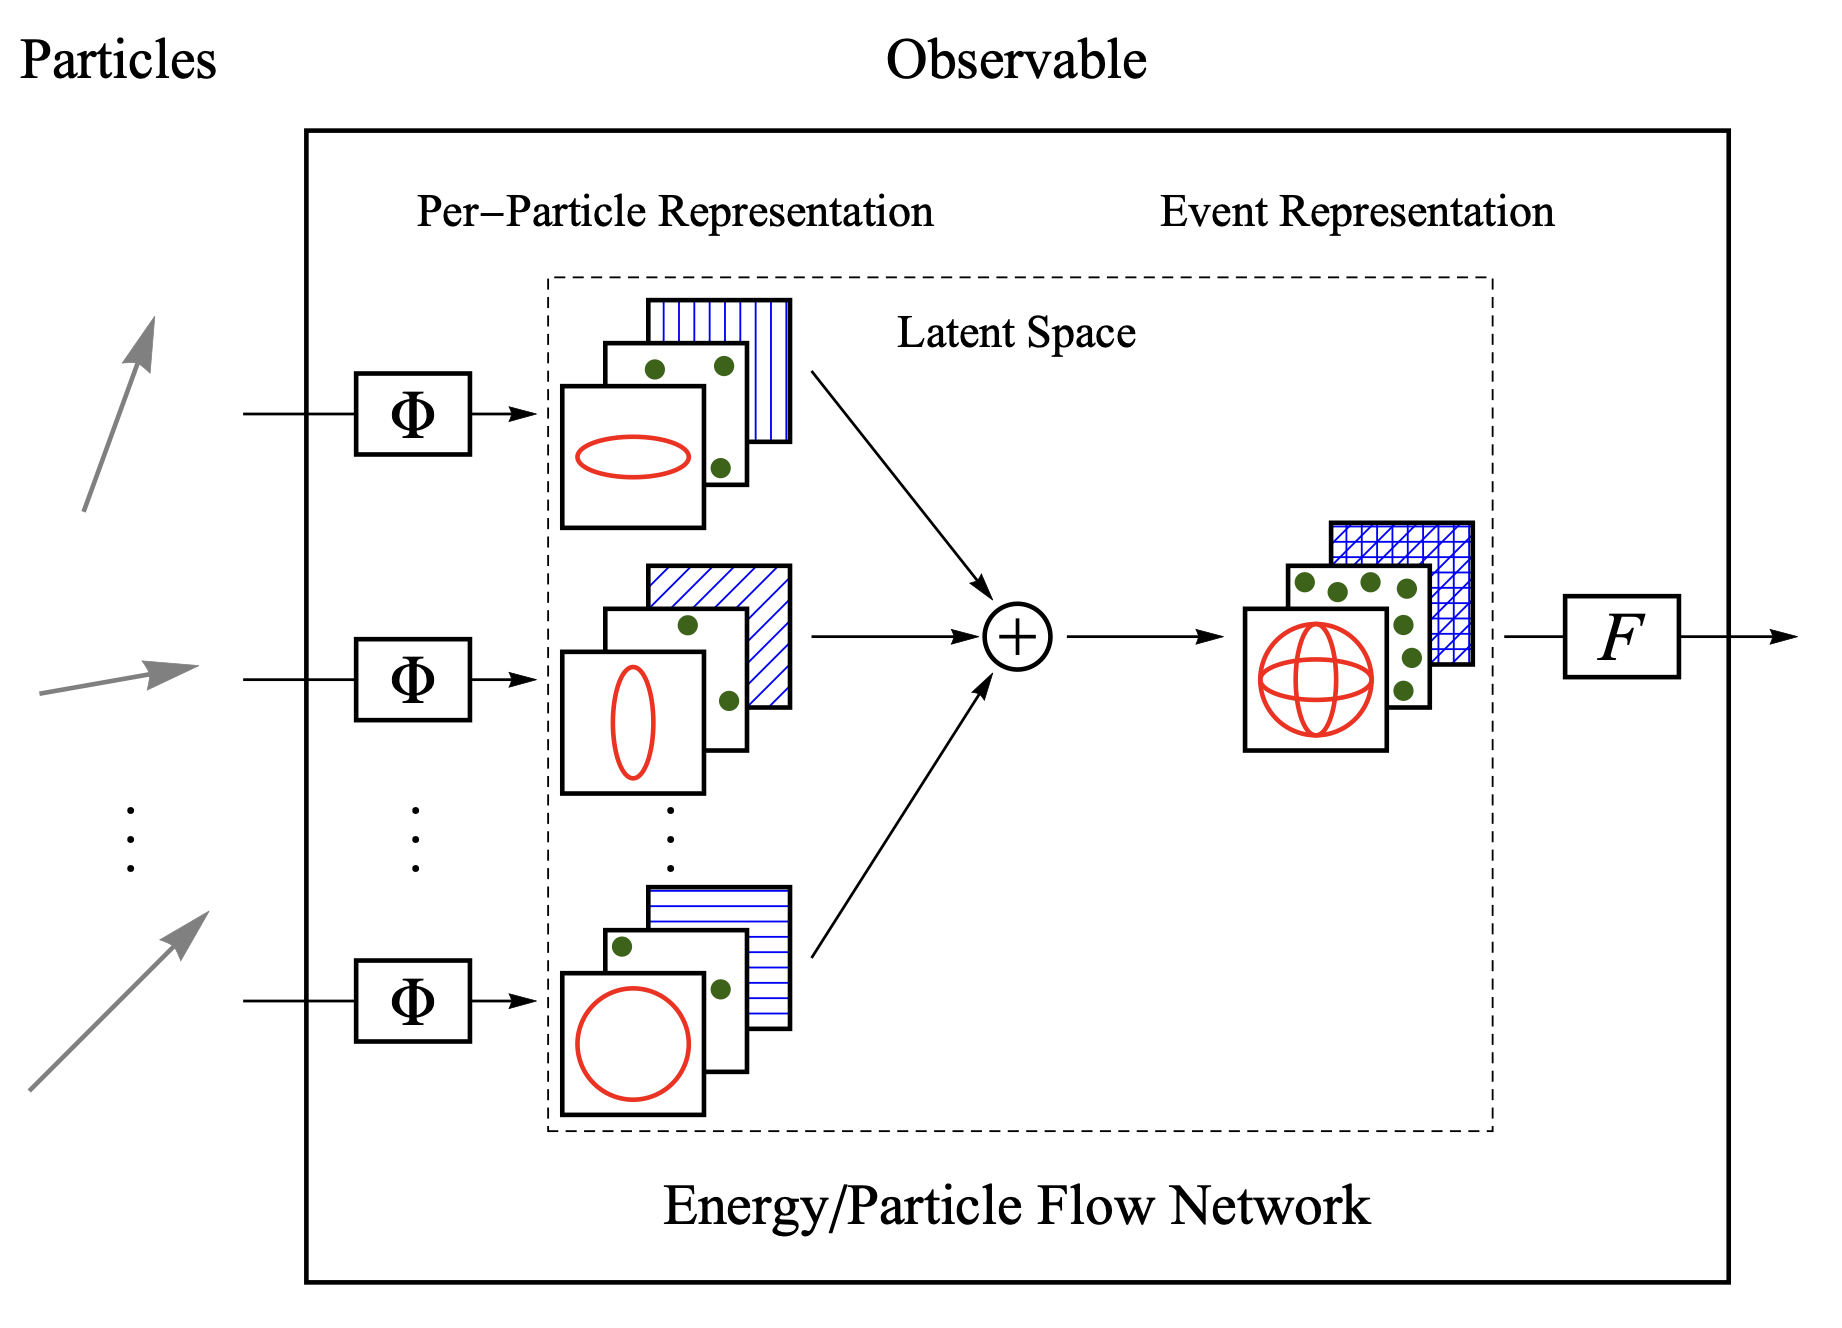

In [ ]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 100
batch_size = 256

print('Model summary:')

# build architecture
efn = EFN(input_dim = 2, Phi_sizes = Phi_sizes, F_sizes = F_sizes)

Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    300         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                               

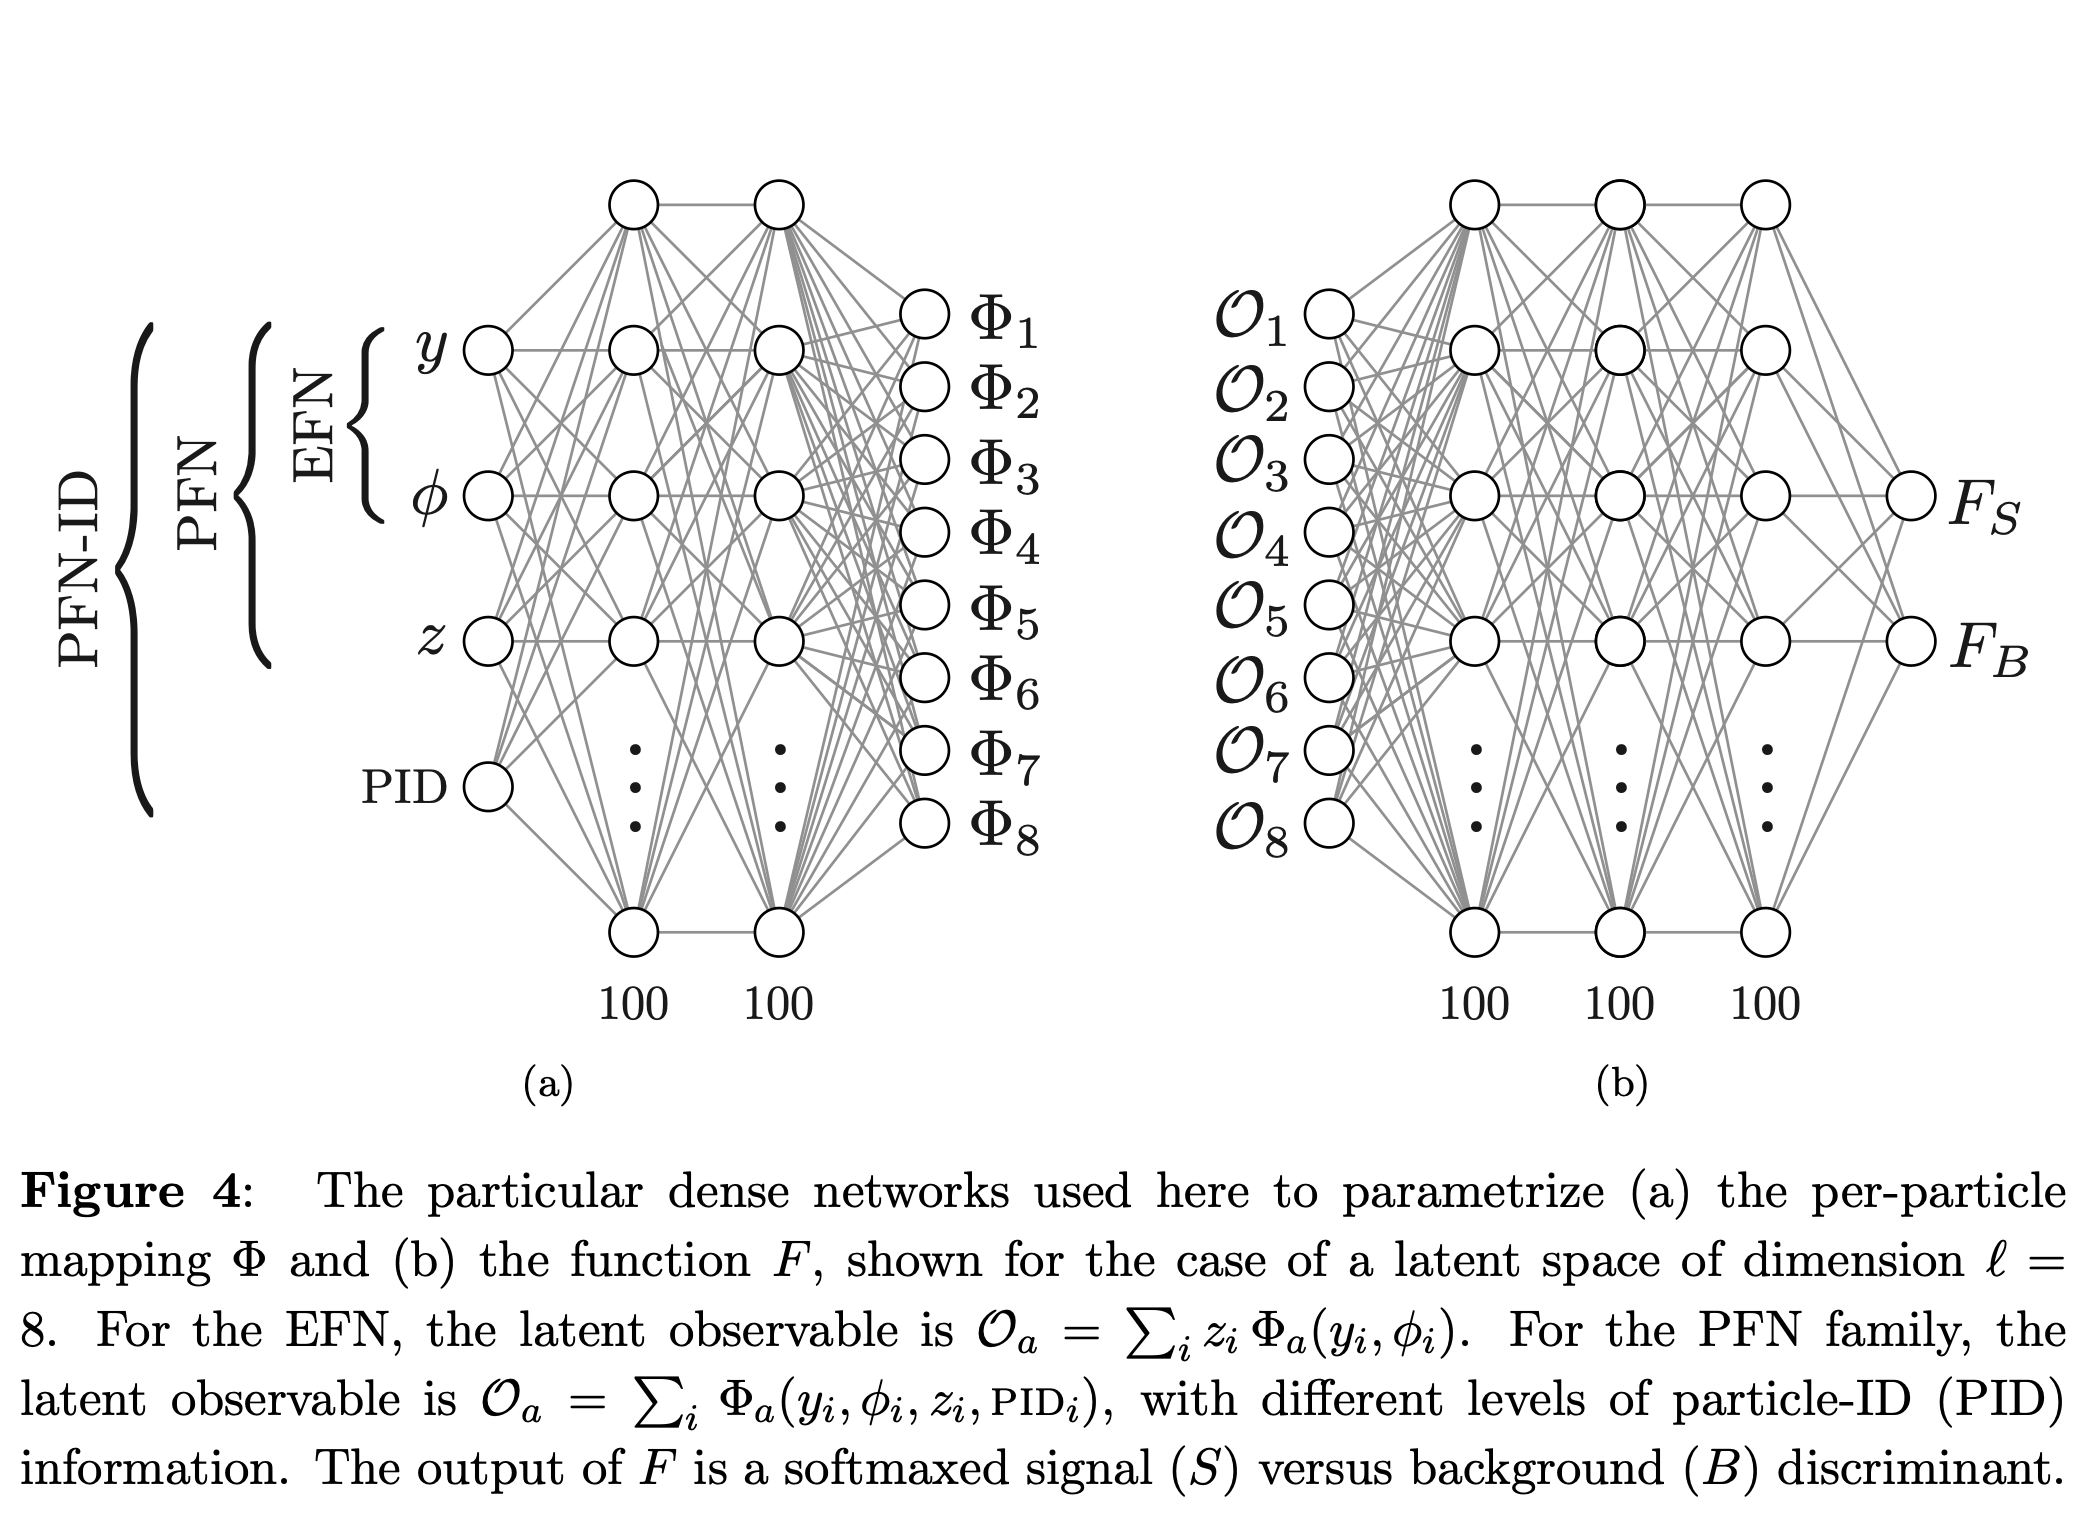

In [ ]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    300         ['phats_input[0][0]']            
                                                                                                  
 activation_7 (Activation)      (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation_7[0][0]']           
                            

In [ ]:
# train model
efn.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

Epoch 1/100
1172/1172 [==============================] - 19s 10ms/step - loss: 0.5214 - acc: 0.7414 - val_loss: 0.4888 - val_acc: 0.7682
Epoch 2/100
1172/1172 [==============================] - 9s 8ms/step - loss: 0.4862 - acc: 0.7698 - val_loss: 0.4829 - val_acc: 0.7719
Epoch 3/100
1172/1172 [==============================] - 10s 8ms/step - loss: 0.4792 - acc: 0.7747 - val_loss: 0.4813 - val_acc: 0.7728
Epoch 4/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4741 - acc: 0.7785 - val_loss: 0.4742 - val_acc: 0.7779
Epoch 5/100
1172/1172 [==============================] - 10s 8ms/step - loss: 0.4680 - acc: 0.7820 - val_loss: 0.4678 - val_acc: 0.7828
Epoch 6/100
1172/1172 [==============================] - 10s 9ms/step - loss: 0.4623 - acc: 0.7861 - val_loss: 0.4650 - val_acc: 0.7847
Epoch 7/100
1172/1172 [==============================] - 11s 9ms/step - loss: 0.4582 - acc: 0.7890 - val_loss: 0.4606 - val_acc: 0.7869
Epoch 8/100
1172/1172 [=========================

In [ ]:
res = efn.evaluate([z_test, p_test], y_test)

print("Test loss: ", res[0])
print("Test accuracy: ", res[1])

3125/3125 [==============================] - 10s 3ms/step - loss: 1.1717 - acc: 0.5013
Test loss:  1.1716506481170654
Test accuracy:  0.5013099908828735


### Comparison of Results

| Model | Train |      |     | Test |      |     | Validation |      |     |
|-------|-------|------|-----|------|------|-----|------------|------|-----|
|       | Acc   | Loss |     | Acc  | Loss |     | Acc        | Loss |     |
| ParticleNet-Lite | 0.8154| 0.4165|     | 0.8093| 0.4268|     | 0.8087| 0.4275|     |
| EFN   | 0.8262| 0.3970|     | 0.5013| 1.1717|     | 0.7974| 0.4586|     |

Conclusion:

- The "ParticleNet-Lite" model performed better than the "EFN" model on all three metrics: Train Accuracy, Test Accuracy, and Validation Accuracy.

- The "EFN" model achieved a lower Train Loss than the "ParticleNet-Lite" model, but its Test Loss is significantly higher than the "ParticleNet-Lite" model. This suggests that the "EFN" model is overfitting on the training data and does not generalize well to the test data.

- The "ParticleNet-Lite" model achieved a similar Validation Loss to the "EFN" model, indicating that it is not overfitting on the training data and can generalize well to unseen data.

Overall, these results suggest that the "ParticleNet-Lite" model is the better performing model between the two, as it achieved higher accuracy on all three metrics while maintaining a relatively low test loss. However, further analysis would be required to determine the significance of the differences in the accuracy and loss between the two models.




### References

[1] [Energy Flow Networks: Deep Sets for Particle Jets](https://arxiv.org/pdf/1810.05165.pdf)

[2] [ParticleNet: Jet Tagging via Particle Clouds](https://arxiv.org/abs/1902.08570)
